In [1]:
dataset_path = '/mnt/edisk/dataset/imagenet-mini/val'
qmodel_path = 'quantized.onnx'
model_path = 'origin.onnx'

In [2]:
from tqdm import tqdm
import pickle

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from torch.ao.quantization.observer import HistogramObserver, PerChannelMinMaxObserver
from torch.ao.quantization.fake_quantize import FakeQuantizeBase, FakeQuantize

from onnxutils.common import DatasetUtils
from onnxutils.quantization import symbolic_trace, ModuleQuantizer, compute_metrics

from imagenet_pipeline import ImageNetPipeline

# Prepare

In [3]:
class M(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(3, 3, 3, padding=1, bias=False)
        self.relu = nn.ReLU()

        self.conv0 = nn.Conv2d(3, 3, 3, padding=1, bias=False)
        self.relu0 = nn.ReLU()
    def forward(self, x):
        x = self.conv(x)
        x = self.relu(x)

        x = self.conv0(x)
        x = self.relu0(x)
        return x

In [4]:
dataset = ImageNetPipeline.get_dataset(dataset_path)
torch_model = M()

torch_model.conv.reset_parameters()
torch_model.conv0.reset_parameters()

# Analysis

# Quantization

In [5]:
graph_model = pickle.loads(pickle.dumps(torch_model))
graph_model = symbolic_trace(graph_model)

quantizer = ModuleQuantizer()
graph_model = quantizer.quantize(graph_model, [
    {
        'name': 'relu',
        'activation': FakeQuantize.with_args(observer=HistogramObserver),
    },
    {
        'module_name': 'conv0',
        'weight': FakeQuantize.with_args(observer=PerChannelMinMaxObserver),
    },
    {
        'module_name': 'relu0',
        'activation': FakeQuantize.with_args(observer=HistogramObserver),
    },
])

graph_model.print_readable()

class GraphModule(torch.nn.Module):
    def forward(self, x):
         # File: /opt/miniconda3/lib/python3.10/site-packages/torch/fx/proxy.py:219 in create_proxy, code: proxy.node.stack_trace = ''.join(CapturedTraceback.extract().format())
        conv = self.conv(x);  x = None
        
         # File: /opt/miniconda3/lib/python3.10/site-packages/torch/fx/proxy.py:219 in create_proxy, code: proxy.node.stack_trace = ''.join(CapturedTraceback.extract().format())
        relu = self.relu(conv);  conv = None
        
        # No stacktrace found for following nodes
        fq0 = self.fq0(relu);  relu = None
        
         # File: /opt/miniconda3/lib/python3.10/site-packages/torch/fx/proxy.py:219 in create_proxy, code: proxy.node.stack_trace = ''.join(CapturedTraceback.extract().format())
        conv0 = self.conv0(fq0);  fq0 = None
        
         # File: /opt/miniconda3/lib/python3.10/site-packages/torch/fx/proxy.py:219 in create_proxy, code: proxy.node.stack_trace = ''.join(Captur

"class GraphModule(torch.nn.Module):\n    def forward(self, x):\n         # File: /opt/miniconda3/lib/python3.10/site-packages/torch/fx/proxy.py:219 in create_proxy, code: proxy.node.stack_trace = ''.join(CapturedTraceback.extract().format())\n        conv = self.conv(x);  x = None\n        \n         # File: /opt/miniconda3/lib/python3.10/site-packages/torch/fx/proxy.py:219 in create_proxy, code: proxy.node.stack_trace = ''.join(CapturedTraceback.extract().format())\n        relu = self.relu(conv);  conv = None\n        \n        # No stacktrace found for following nodes\n        fq0 = self.fq0(relu);  relu = None\n        \n         # File: /opt/miniconda3/lib/python3.10/site-packages/torch/fx/proxy.py:219 in create_proxy, code: proxy.node.stack_trace = ''.join(CapturedTraceback.extract().format())\n        conv0 = self.conv0(fq0);  fq0 = None\n        \n         # File: /opt/miniconda3/lib/python3.10/site-packages/torch/fx/proxy.py:219 in create_proxy, code: proxy.node.stack_trace =

In [6]:
# calibration
for m in graph_model.modules():
    if isinstance(m, FakeQuantizeBase):
        m.disable_fake_quant()

dataloader = DataLoader(
    DatasetUtils.take_front(
        DatasetUtils.transform(
            dataset,
            lambda items: (items[0].to('cuda'),)
        ),
        2048
    ),
    batch_size=64
)
graph_model.eval().to('cuda')
for data in tqdm(dataloader):
    graph_model(*data)

for m in graph_model.modules():
    if isinstance(m, FakeQuantizeBase):
        m.enable_fake_quant()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.79it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:35<00:00,  1.40it/s]


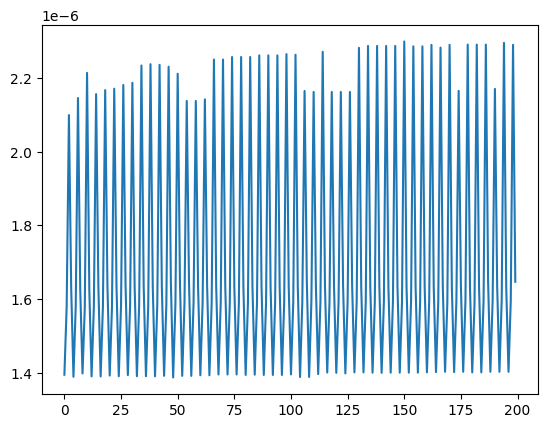

In [7]:
# QAT Training
dataloader = DataLoader(
    DatasetUtils.take_front(
        DatasetUtils.transform(
            dataset,
            lambda items: (items[0].to('cuda'),)
        ),
        256
    ),
    batch_size=64
)
torch_model.eval().to('cuda')
graph_model.train().to('cuda')

loss_vals = []
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(graph_model.parameters(), lr=1e-5)

for _ in tqdm(range(50)):
    for data in dataloader:
        gt = torch_model(*data)
        pred = graph_model(*data)

        loss = loss_fn(pred, gt)
        loss_vals.append(loss.detach().cpu().item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

plt.plot(loss_vals)

# Preview

In [8]:
dataloader = DataLoader(
    DatasetUtils.drop_front(
        DatasetUtils.transform(
            dataset,
            lambda items: (items[0].to('cuda'),)
        ),
        256
    ),
    batch_size=16
)
torch_model.eval().to('cuda')
graph_model.eval().to('cuda')

for data in dataloader:
    gt = torch_model(*data)
    pred = graph_model(*data)

    print(compute_metrics(gt, pred))
    gt = gt.reshape(-1, 1)
    pred = pred.reshape(-1, 1)
    print(torch.cat([gt, pred], dim=1)[:100])
    break

{'cosine': tensor([0.9998, 0.9999, 0.9999, 0.9999, 1.0000, 0.9999, 0.9999, 0.9999, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 0.9999, 1.0000, 1.0000],
       device='cuda:0', grad_fn=<SumBackward1>), 'snr': tensor([ 7298.3008,  6594.6875,  7810.6650, 13196.5830,   772.2912,  8909.3281,
        12764.7178,  8315.0957,  4142.8892,  8036.9780,  6218.1924,  7174.8955,
         6285.5527,  8354.4844,  2720.9617,  3406.0027], device='cuda:0',
       grad_fn=<SumBackward1>), 'mse': tensor([1.8306e-06, 1.5175e-06, 9.6813e-07, 1.2835e-06, 1.3121e-06, 1.4554e-06,
        1.3160e-06, 8.4430e-07, 2.2235e-06, 1.6355e-06, 9.6082e-07, 1.7389e-06,
        1.6950e-06, 1.6777e-06, 1.2848e-06, 6.1498e-06], device='cuda:0',
       grad_fn=<MeanBackward1>)}
tensor([[0.0838, 0.0835],
        [0.1519, 0.1502],
        [0.1428, 0.1419],
        [0.1416, 0.1419],
        [0.1404, 0.1419],
        [0.1423, 0.1419],
        [0.1442, 0.1461],
        [0.1476, 0.1461],
        [0.1481, 0.1461],
        [0.145

# Export

In [9]:
finalized_model = quantizer.finalize(graph_model).to('cuda')
torch.onnx.export(
    finalized_model,
    tuple(next(iter(dataloader))),
    qmodel_path,
    input_names=['x'],
    output_names=['y'],
)
torch.onnx.export(
    torch_model,
    tuple(next(iter(dataloader))),
    model_path,
    input_names=['x'],
    output_names=['y'],
)